#### The Dataset
###### Packages

In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score, recall_score, fbeta_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import optuna
from imblearn.under_sampling import RandomUnderSampler
import optuna.visualization as vis
import numpy as np
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\maria\AppData\Local\Programs\Python\Python312\python.exe


In [10]:
df = pd.read_csv(r"Churn_clean.csv")
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,log_Imp_Bonifici_vs_Competitors,log_Imp_Bonifici_vs_No_Competitors,log_Imp_Gestito_attuale,log_Num_Punti_Programma_Loyalty
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,2978.40,2980.92,0,0,0,0,NaN,2.909984,3.473983,NaN
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,NaN,34916.15,0,0,0,0,3.796631,2.918093,NaN,2.511883
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,NaN,232776.62,1,0,0,0,3.636488,3.032081,NaN,2.662758
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,15013.53,15017.53,0,0,0,0,NaN,NaN,4.176483,NaN
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,NaN,NaN,0,0,0,0,NaN,3.079181,NaN,3.562293


In [11]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Convert in 0 and 1
XX = pd.get_dummies(X)


In [12]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train = pd.get_dummies(X)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train.align(X_test, join='inner', axis=1)


#### The Synthetic dataset

In [14]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

In [15]:
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 280)


#### LightGBM 
###### This alghoritm is the fastest one, so we used this one to evaluate and chose the best metric
##### Hyperparameters Tuning
###### This tuning has been worked for different metrics, in order to estabilish the best parameters for each metric

In [ ]:

def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        #y_fold_val dovrebbe essere 30190, prendiamo in rapporto circa 1:6
        #the following 4 lines were been changed for the different metrics
        top_indices = np.argsort(probas)[-5000:]  # Get top 10,000 indices
        top_positives = y_fold_val.iloc[top_indices].sum()  # Count of positives in the top 10,000
        total_positives = y_fold_val.sum()  # Total positives in the validation set
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  # Calculate the ratio

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)


##### Metric: Rank Probabilities

In [17]:
'''
Best Hyperparameters: {'n_estimators': 195, 'learning_rate': 0.0689356536665432, 'max_depth': 13, 'num_leaves': 1946, 'min_child_samples': 37, 'subsample': 0.8841796423370363, 'subsample_freq': 0, 'colsample_bytree': 0.783386192594209, 'reg_alpha': 0.7592044537020304, 'reg_lambda': 0.538402350448647, 'max_bin': 269}
Best ROC AUC Score: 0.9918504426589758
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    'n_estimators': 264,
    'learning_rate': 0.011142632664740155,
    'max_depth': 11,
    'num_leaves': 28,
    'min_child_samples': 37,
    'subsample': 0.8024511835587035,
    'subsample_freq': 7,
    'colsample_bytree': 0.883133308624884,
    'reg_alpha': 0.8745173652189913,
    'reg_lambda': 0.9687219187179391,
    'max_bin': 244,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}


best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [18]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
6844         1      0.945870
17390        1      0.932907
5648         1      0.929964
365477       0      0.929283
21801        0      0.927659
...        ...           ...
331392       0      0.549789
361166       0      0.549775
303967       0      0.549750
191639       0      0.549734
6091         0      0.549731

[10000 rows x 2 columns]


In [19]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 299
Numero di 'SI: nel nostro test set 383


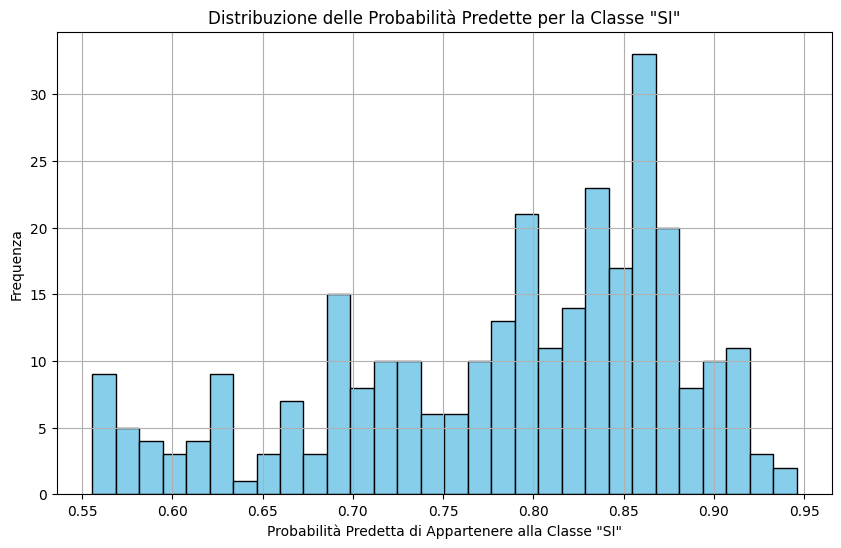

In [20]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

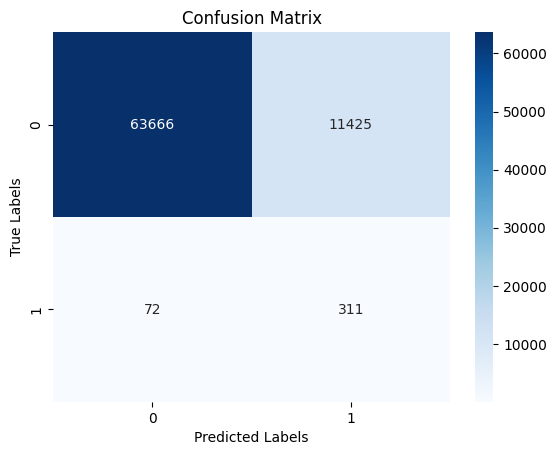

In [21]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Rank probabilities on the synthetic dataset

In [22]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
22917       0      0.913489
6976        0      0.886913
4695        0      0.881475
8458        0      0.879618
58700       0      0.874516
...       ...           ...
23206       0      0.395665
6322        0      0.395661
10735       0      0.395556
30003       0      0.395556
7888        0      0.395519

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 224
Numero di 'SI: nel nostro test set 489


#### Metric: Roc Auc

In [23]:
best_params = {
    'n_estimators': 264,
    'learning_rate': 0.011142632664740155,
    'max_depth': 11,
    'num_leaves': 28,
    'min_child_samples': 37,
    'subsample': 0.8024511835587035,
    'subsample_freq': 7,
    'colsample_bytree': 0.883133308624884,
    'reg_alpha': 0.8745173652189913,
    'reg_lambda': 0.9687219187179391,
    'max_bin': 244,
    'force_col_wise': True,
    'verbosity': -1
}
best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [24]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17390        1      0.840684
17391        1      0.730329
16647        1      0.717152
6844         1      0.648397
5648         1      0.621765
...        ...           ...
97135        0      0.007439
36299        0      0.007438
323707       0      0.007438
212886       0      0.007437
170105       0      0.007437

[10000 rows x 2 columns]


In [25]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 303
Numero di 'SI: nel nostro test set 383


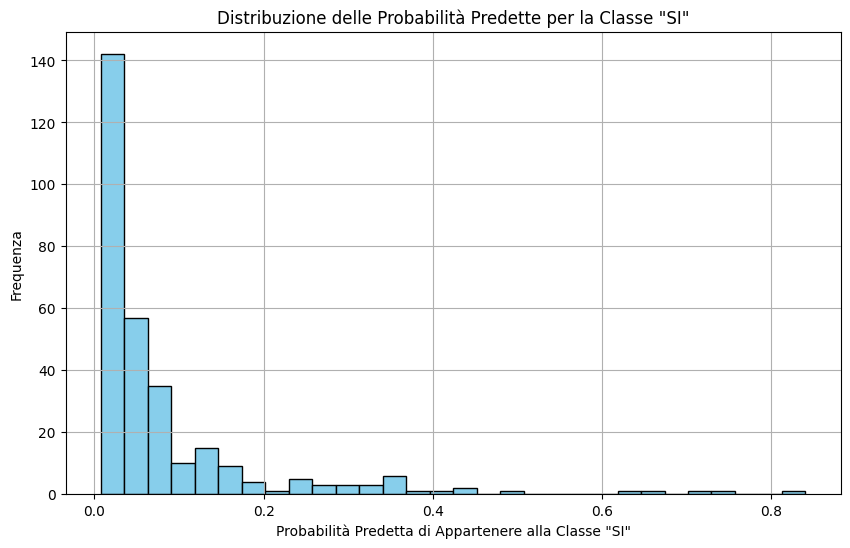

In [26]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

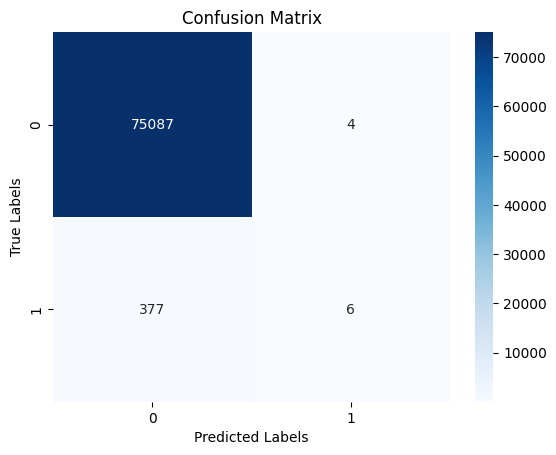

In [27]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Roc Auc on the synthetic dataset

In [28]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
27984       0      0.194357
65874       0      0.168901
58238       0      0.162919
19193       0      0.160197
25443       0      0.158478
...       ...           ...
15598       0      0.005178
5307        0      0.005177
24296       0      0.005177
60595       0      0.005177
16444       0      0.005176

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 227
Numero di 'SI: nel nostro test set 489


In [29]:
X_test.iloc[2]

Imp_Valore_del_Cliente         18.45
Flag_Apertura_Conto_Online         0
Flag_Possesso_piu_Conti            0
Eta                             32.0
Anno_Apertura_primo_Conto     2004.0
                               ...  
Tipologia_Cliente_Investor      True
Tipologia_Cliente_Sleeper      False
Tipologia_Cliente_Trader       False
Sesso_F                        False
Sesso_M                         True
Name: 229951, Length: 280, dtype: object

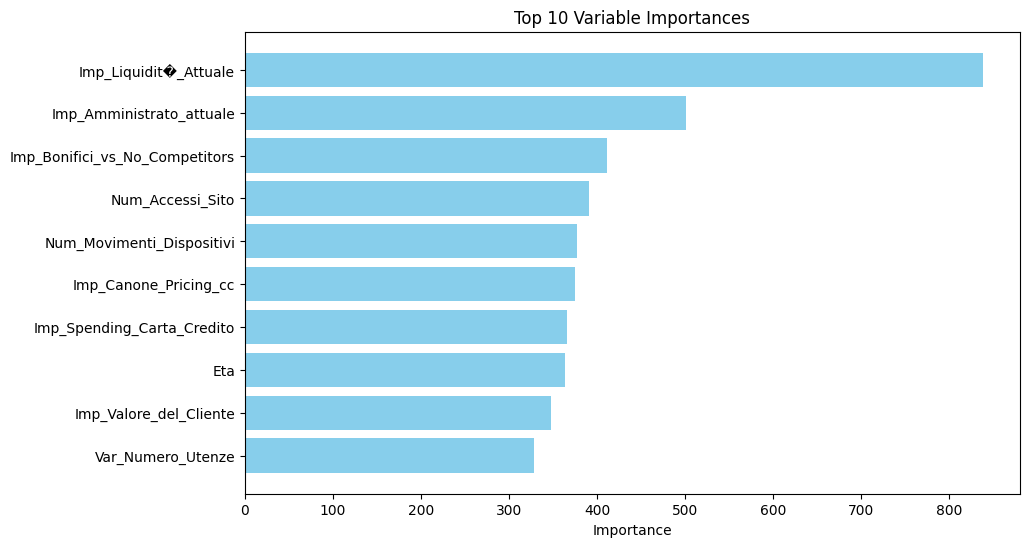

In [30]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


#### Metric:Recall

In [31]:
best_params = {
    'n_estimators': 223,
    'learning_rate': 0.02473710933735549,
    'max_depth': 5,
    'num_leaves': 29,
    'min_child_samples': 28,
    'subsample': 0.9979287455244378,
    'subsample_freq': 5,
    'colsample_bytree': 0.9997861136218631,
    'reg_alpha': 0.9741083680472568,
    'reg_lambda': 0.9792814931859342,
    'max_bin': 240,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [32]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
54805        1      0.993619
6844         1      0.990314
17390        1      0.987667
19464        1      0.985067
20382        1      0.984839
...        ...           ...
198414       0      0.600030
103216       0      0.599984
208008       0      0.599950
359632       0      0.599919
361500       0      0.599908

[10000 rows x 2 columns]


In [33]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI': nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 291
Numero di 'SI': nel nostro test set 383


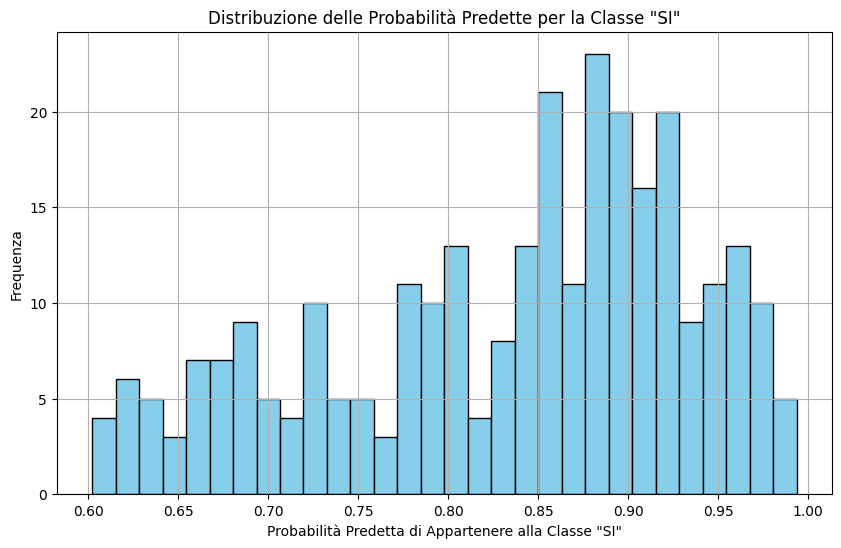

In [34]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

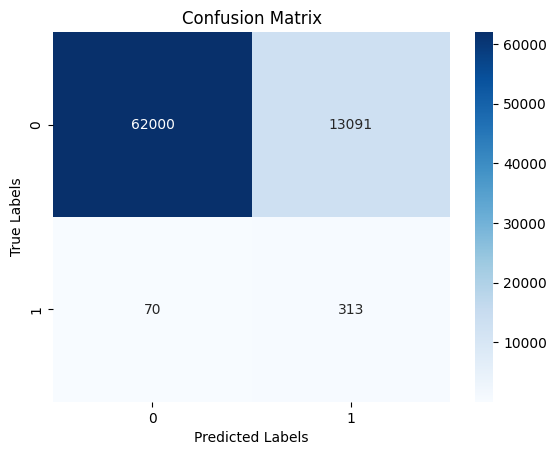

In [35]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Recall on the synthetic dataset

In [36]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
33297       0      0.974519
33094       0      0.971336
25443       0      0.966498
27898       1      0.964541
12659       0      0.959407
...       ...           ...
45812       0      0.491162
28408       0      0.491136
56642       0      0.491125
55057       0      0.491096
41537       0      0.491086

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 206
Numero di 'SI: nel nostro test set 489


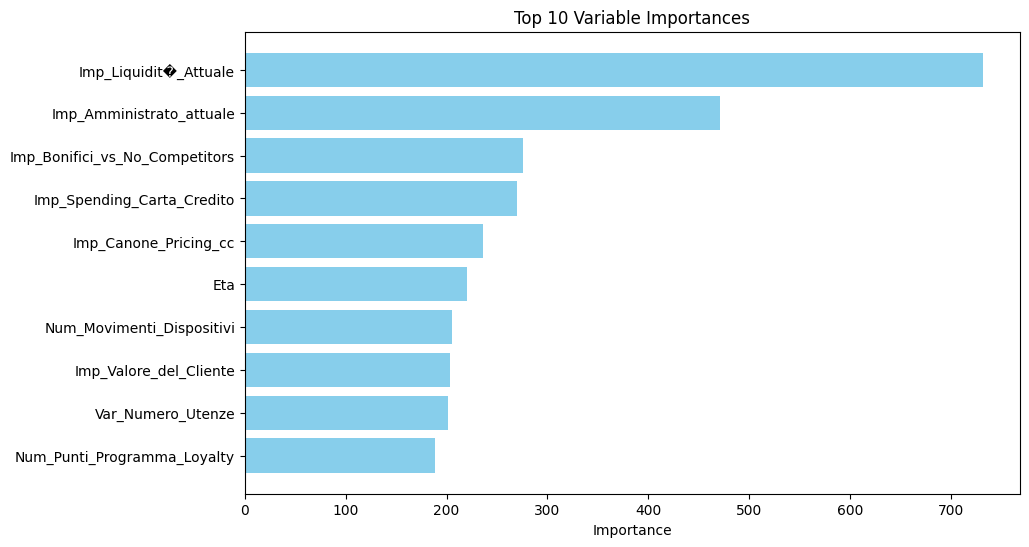

In [37]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


#### Metric: Precision

In [38]:
best_params = {
    'n_estimators': 222,
    'learning_rate': 0.0035234408126281255,
    'max_depth': 15,
    'num_leaves': 36,
    'min_child_samples': 50,
    'subsample': 0.8024949185836124,
    'subsample_freq': 1,
    'colsample_bytree': 0.694085486904971,
    'reg_alpha': 0.002310729712339969,
    'reg_lambda': 0.8359805786791278,
    'max_bin': 231,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}


best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [39]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
6844         1      0.582805
532          0      0.573442
19479        1      0.562042
130546       0      0.559044
17391        1      0.558076
...        ...           ...
312050       0      0.311092
91168        0      0.311086
167766       0      0.311071
351558       0      0.311063
193122       0      0.311052

[10000 rows x 2 columns]


In [40]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 295
Numero di 'SI: nel nostro test set 383


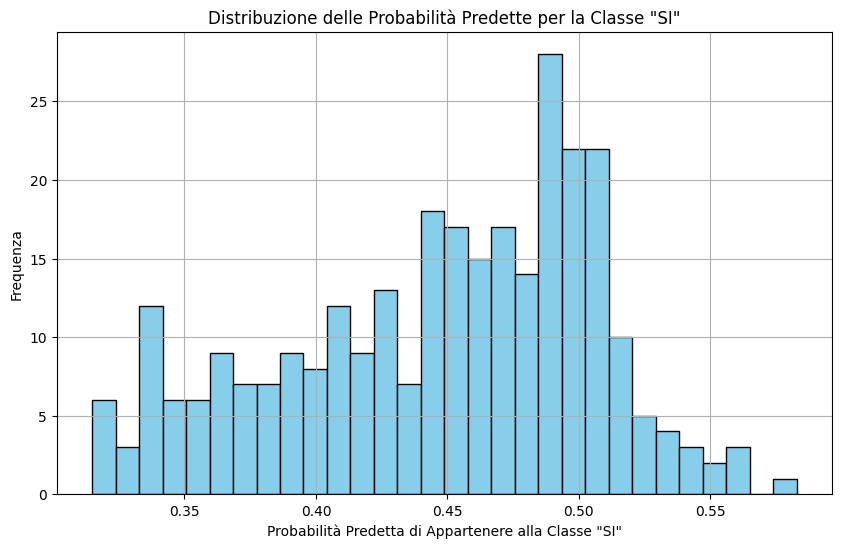

In [41]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

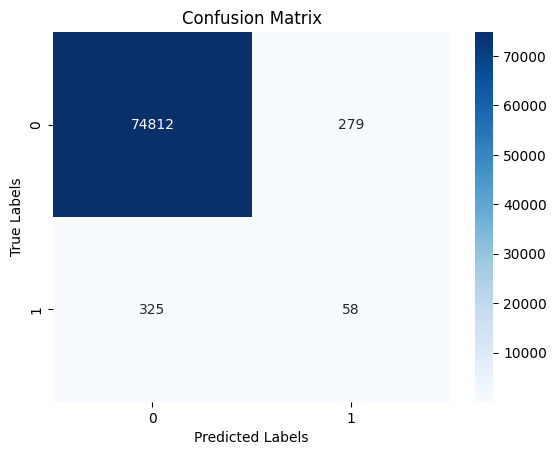

In [42]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Precision on the synthetic dataset

In [43]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
8111        0      0.505461
4695        0      0.505404
23320       0      0.502584
12775       0      0.496432
48850       0      0.496103
...       ...           ...
30387       0      0.213913
8009        0      0.213910
16073       0      0.213905
9820        0      0.213898
16296       0      0.213872

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 208
Numero di 'SI: nel nostro test set 489


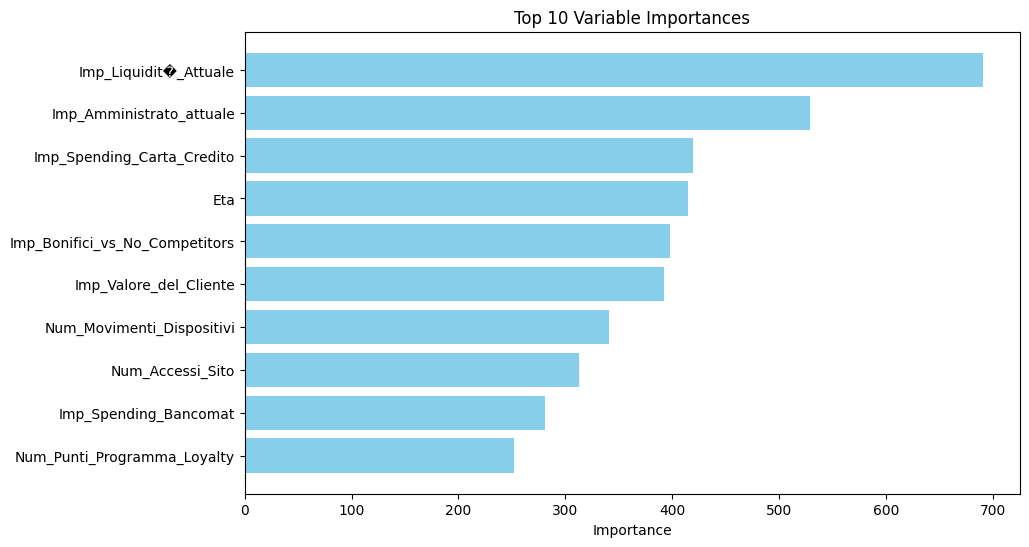

In [44]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


#### Metric:F1 score

In [45]:
best_params = {
    'n_estimators': 114,
    'learning_rate': 0.006680983417211186,
    'max_depth': 6,
    'num_leaves': 38,
    'min_child_samples': 35,
    'subsample': 0.8661796049705299,
    'subsample_freq': 0,
    'colsample_bytree': 0.7243929286862649,
    'reg_alpha': 0.32518332202674705,
    'reg_lambda': 0.7296061783380641,
    'max_bin': 264,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight, 
    'verbosity': -1
}

In [46]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
6844         1      0.582805
532          0      0.573442
19479        1      0.562042
130546       0      0.559044
17391        1      0.558076
...        ...           ...
312050       0      0.311092
91168        0      0.311086
167766       0      0.311071
351558       0      0.311063
193122       0      0.311052

[10000 rows x 2 columns]


In [47]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 295
Numero di 'SI: nel nostro test set 383


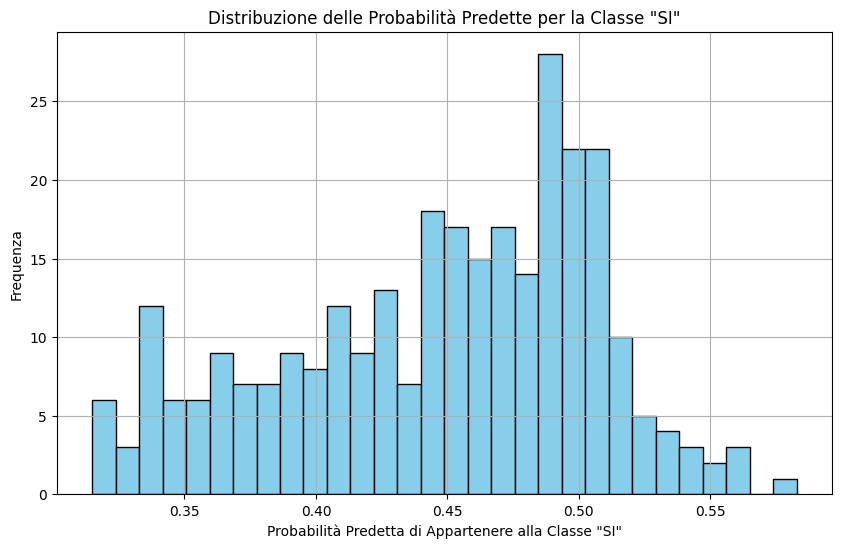

In [48]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

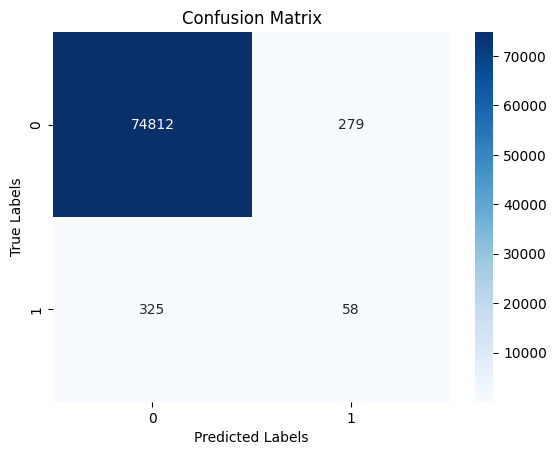

In [49]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

F1 on the synthetic dataset

In [50]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
8111        0      0.505461
4695        0      0.505404
23320       0      0.502584
12775       0      0.496432
48850       0      0.496103
...       ...           ...
30387       0      0.213913
8009        0      0.213910
16073       0      0.213905
9820        0      0.213898
16296       0      0.213872

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 208
Numero di 'SI: nel nostro test set 489


#### Metric:F2 beta

In [51]:
best_params = {
    'n_estimators': 223,
    'learning_rate': 0.0038506136777269,
    'max_depth': 15,
    'num_leaves': 31,
    'min_child_samples': 49,
    'subsample': 0.9616132068894329,
    'subsample_freq': 6,
    'colsample_bytree': 0.6113887387854107,
    'reg_alpha': 0.0200533381277905,
    'reg_lambda': 0.4152066163632999,
    'max_bin': 233,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)

best_lgb_classifier.fit(X_train, y_train)

lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]


In [52]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
130546       0      0.586486
6844         1      0.585939
17390        1      0.574370
21801        0      0.572787
17391        1      0.570849
...        ...           ...
22121        0      0.336877
302261       0      0.336787
63049        0      0.336774
362859       0      0.336763
287342       0      0.336752

[10000 rows x 2 columns]


In [53]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 289
Numero di 'SI: nel nostro test set 383


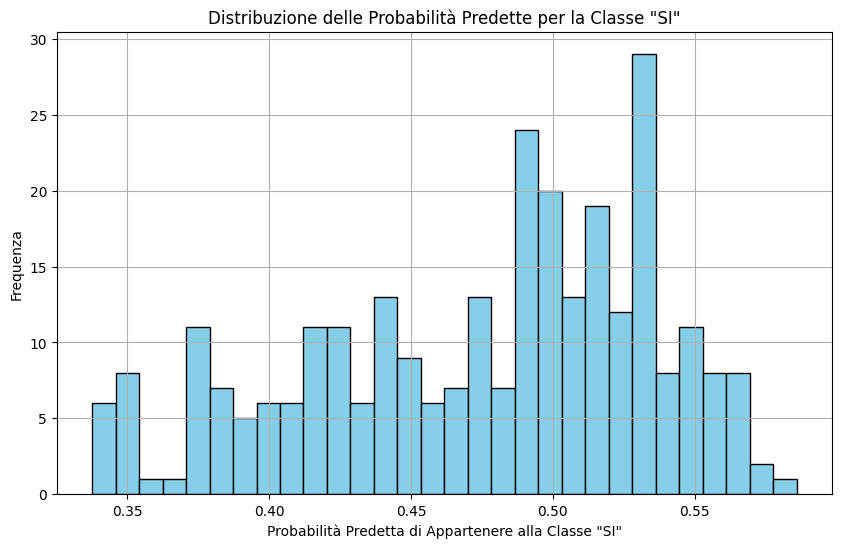

In [54]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

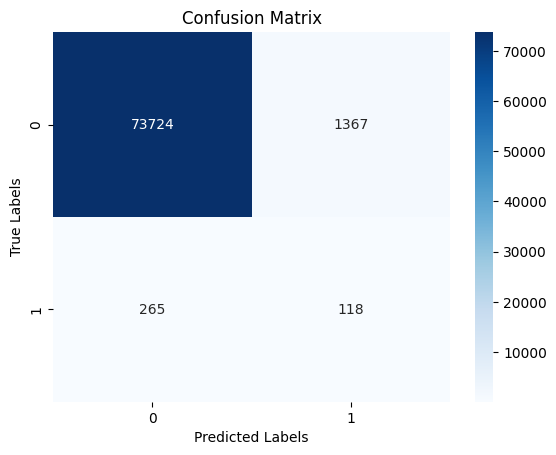

In [55]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


F2 on the synthetic dataset

In [56]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(10000)
print(top_100_si)
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

       y_test  y_pred_proba
19193       0      0.546335
12775       0      0.542086
55488       0      0.539985
48488       0      0.536424
8111        0      0.535700
...       ...           ...
1148        0      0.235635
45925       0      0.235619
46096       0      0.235606
40939       0      0.235598
64709       0      0.235578

[10000 rows x 2 columns]
Numero di 'SI' nei nostri 10k: 219
Numero di 'SI: nel nostro test set 489


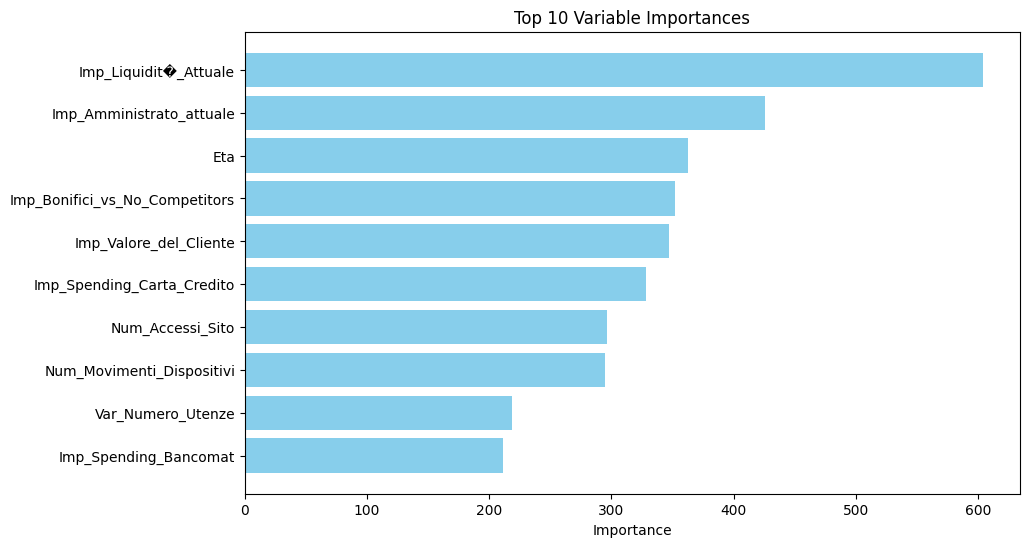

In [57]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()
